# A naive implementation of a QRAM

In questo notebook, trattiamo l'implementazione di una QRAM. È una prima struttura dati quantistica, un simil vettore capace di contenere valori codificati numericamente, e di effettuare sovrascritture dei valori contenuti.

In [33]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from BoredQiskit import FastQiskit as fq
from BoredQiskit import FastOracles as fo
from BoredQiskit import FastUtilsGate as fg
import numpy as np

In [34]:
def int_to_bin(num: int, code_len: int):
    num = bin(num)[2:]
    num = '0'*(code_len-len(num)) + num
    return num

## Inizializzazione e lettura

Implementiamo la lettura degli indirizzi della QRAM tramite un grande oracolo.

$$
U_v|i\rangle |0\rangle \to |i\rangle|v[i]\rangle
$$

Questo, associerà in maniera opportuna l'indirizzo $i$ fornito in input, con l'elemento $v[i]$.

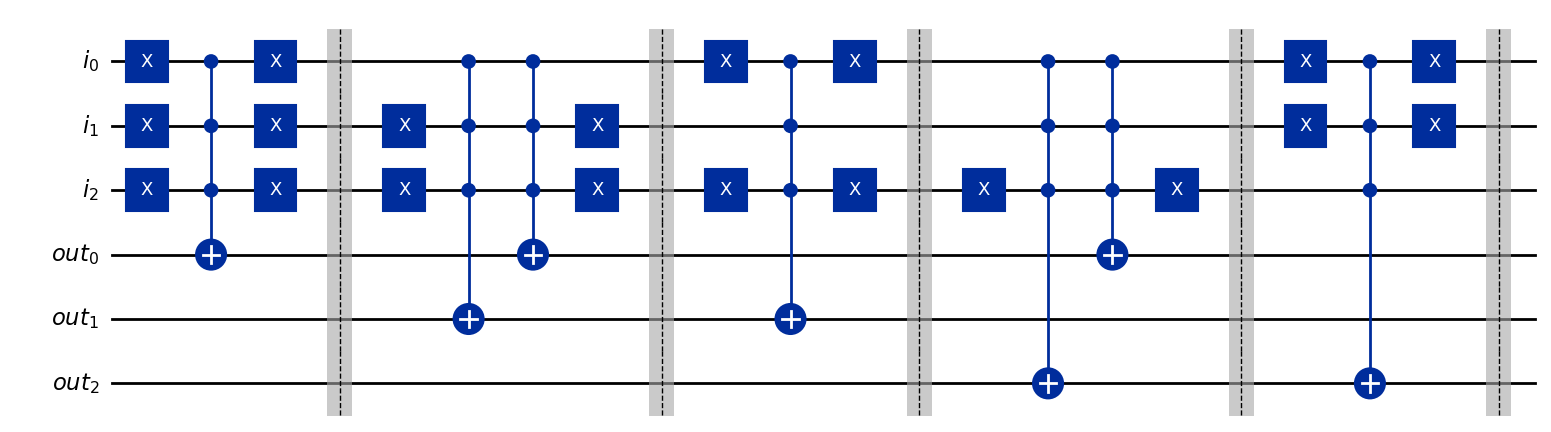

In [35]:
V = [1,3,2,5,4]

def QuantumRAM(v: list[int], barriers=False):
    n = len(v)
    d = int(np.ceil(np.log2(max(v))))
    m = int(np.ceil((np.log2(n))))
    
    ir = QuantumRegister(m, 'i')
    er = QuantumRegister(d, 'out')
    qc = QuantumCircuit(ir,er)

    for j in range(n):
        j_bin = int_to_bin(j, m)
        e_bin = int_to_bin(v[j], d)
        
        if int(e_bin) == 0:
            continue

        for p in [h for h in range(m) if j_bin[h]=='0']:
            qc.x(ir[m-1-p])

        for p in [h for h in range(d) if e_bin[h]=='1']:
            qc.mcx(ir, er[d-1-p])
            
        for p in [h for h in range(m) if j_bin[h]=='0']:
            qc.x(ir[m-1-p])
        if barriers:
            qc.barrier()
    return qc

qram = QuantumRAM(V, barriers=True)
qram.draw('mpl')

In [36]:
def QRAM_gate(v:list[int]):
    qc = QuantumRAM(v)
    
    qram_name = "QRAM:\n"
    for c, n in enumerate(v):
        qram_name = qram_name + str(c) + ": "+ str(n) +";\n"
    return qc.to_gate(label=qram_name)

È interessante osservare la possibilità di fare accessi in sovrapposizione. Definiamo $n$ come il numero di bit di indirizzamento della QRAM.

$$
U_v|i\rangle|0\rangle =  \frac{1}{\sqrt{2}^n}\sum_{x \in \{0,1\}^n}(|x\rangle|v[x]\rangle)
$$


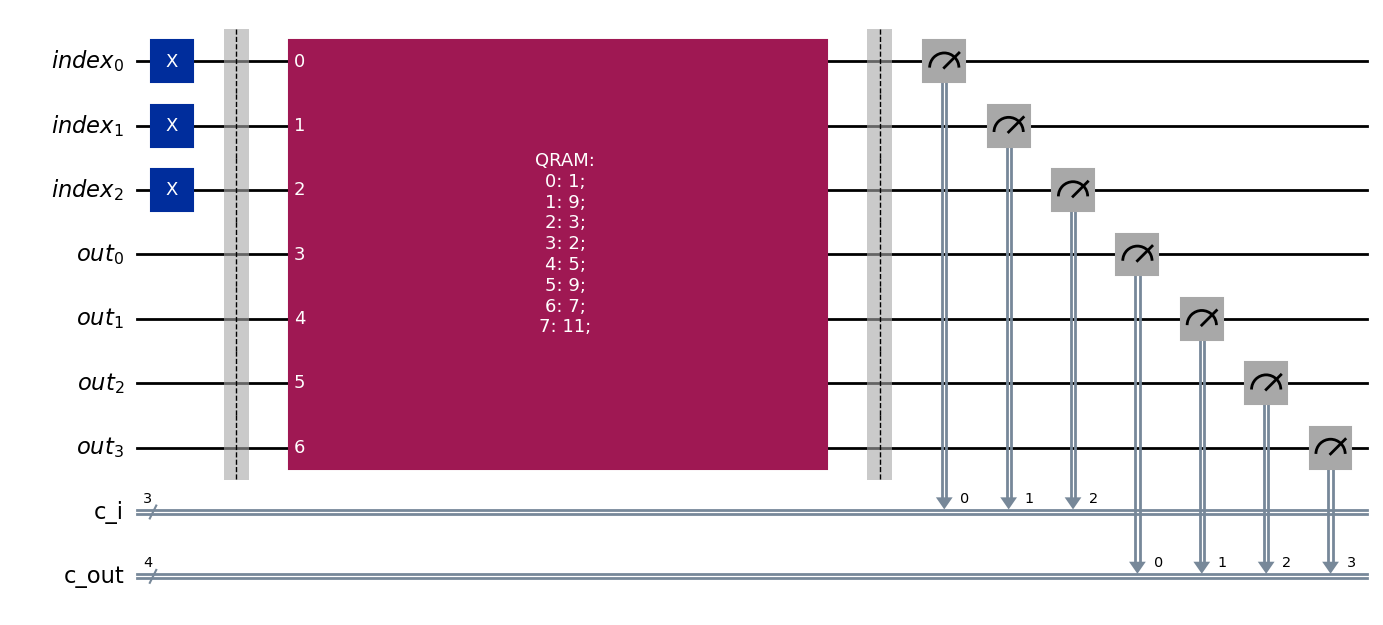

In [37]:
i = QuantumRegister(3, "index")
o = QuantumRegister(4, "out")
c_i = ClassicalRegister(3, "c_i")
c_out = ClassicalRegister(4, "c_out")
qc = QuantumCircuit(i,o,c_i,c_out)
qc.x(i)
qc.barrier()
qc.compose(QRAM_gate([1,9,3,2,5,9,7,11]), inplace=True)
qc.barrier()
qc.measure(i, c_i)
qc.measure(o, c_out)
qc.draw('mpl')

In [38]:
counts = fq.run(qc,1,more_info=True)
print(counts)

{'c_i': {'111': 1}, 'c_out': {'1011': 1}}


## Sovrascrittura di valori nella QRAM

$$
W_v|i\rangle |v[i]\rangle|a\rangle \to |i\rangle|a\rangle|v[i]\rangle
$$

L'idea è quella di sovrascrivere il valore contenuto nella QRAM tramite uno SWAP controllato dall'indirizzo di cui vogliamo sostituire il valore, e che scambia la linea di output con le linee del nuovo valore. 


In [39]:
def QRAM_overwrite_gate(index, index_len, out_len):
    
    ir = QuantumRegister(index_len, 'i')
    out = QuantumRegister(out_len, 'o')
    new_out = QuantumRegister(out_len, 'new_o')
    qc = QuantumCircuit(ir, out, new_out)
    
    index_bin = int_to_bin(index, index_len)
    for j in [i for i in range(index_len) if index_bin[i]=='0']:
            qc.x(ir[index_len-1-j])

    for o in range(out_len):
            qc.mcx([*ir, out[o]], new_out[o])
            qc.mcx([*ir, new_out[o]], out[o])
            qc.mcx([*ir, out[o]], new_out[o])

    for j in [i for i in range(index_len) if index_bin[i]=='0']:
            qc.x(ir[index_len-1-j])

    gate_name = "QRAM overwriting index"+str(index)
    return qc.to_gate(label=gate_name)


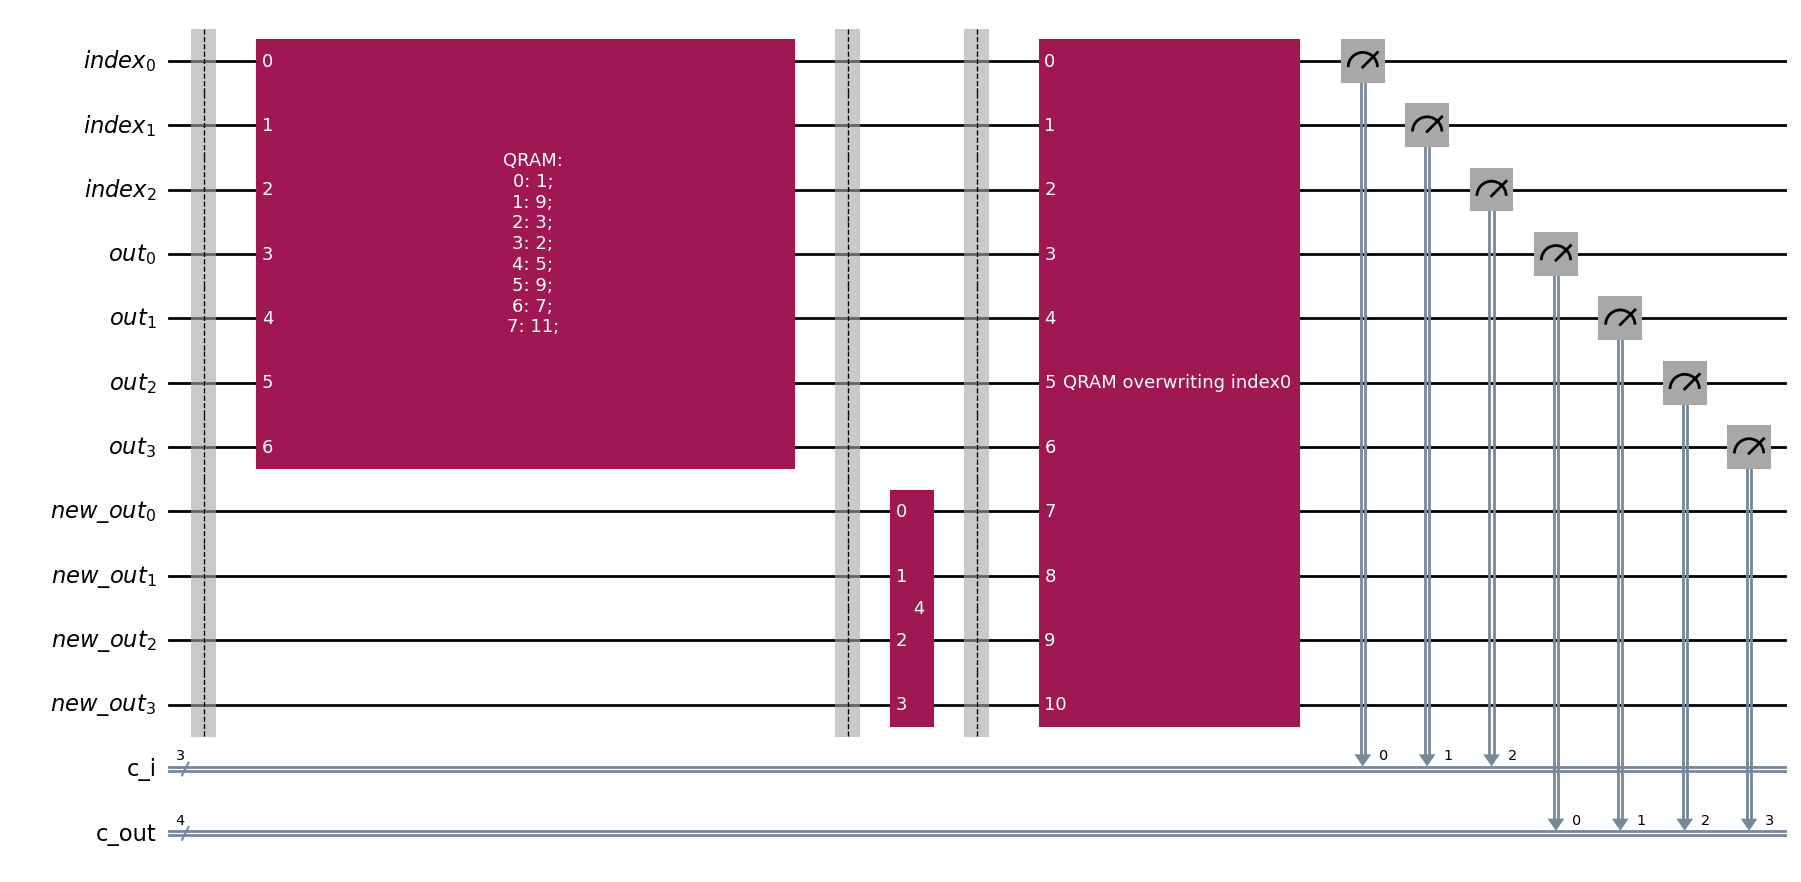

In [40]:
i = QuantumRegister(3, "index")
o = QuantumRegister(4, "out")
new_out = QuantumRegister(4, "new_out")
c_i = ClassicalRegister(3, "c_i")
c_out = ClassicalRegister(4, "c_out")
qc = QuantumCircuit(i,o,c_i,c_out,new_out)
qc.barrier()
qc.compose(QRAM_gate([1,9,3,2,5,9,7,11]), inplace=True)
qc.barrier()
qc.compose(fg.quantum_number_encode(4,4), qubits=new_out, inplace=True)
qc.barrier()
qc.compose(QRAM_overwrite_gate(0,3,4), qubits=[*i, *o, *new_out],inplace=True)
qc.measure(i, c_i)
qc.measure(o, c_out)
qc.draw('mpl')

In [41]:
counts = fq.run(qc,1,more_info=True)
print(counts)

{'c_i': {'000': 1}, 'c_out': {'0100': 1}}


Siamo riusciti con successo a sostituire il valore contenuto nella RAM con un nuovo valore!